### Peal fitting with Radial/azimuthal data


version 2.1.0  Oct 10, 2021 JS
version 2.0.0  April 24, 2021 JS
version 1.0.0  January 10, 2021 JS 

#### This script consists of 2 parts: 1) reading .pkl data. 2) fitting and save as pandas file

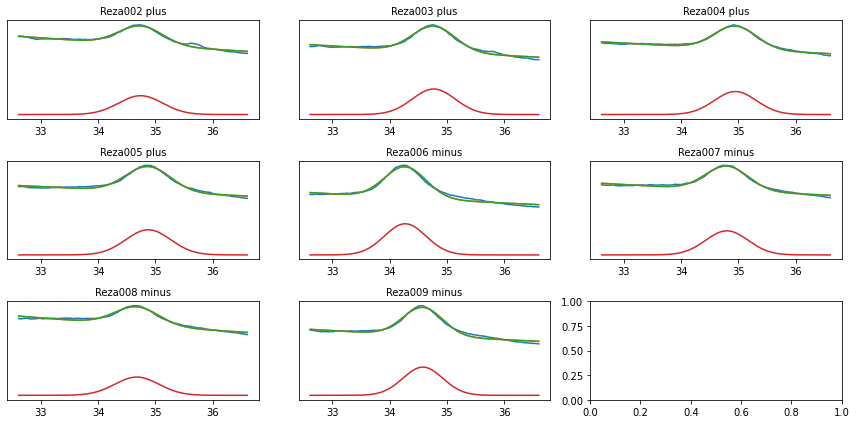

In [9]:
### XRAY_28_DES_2020
### vertical axis is converted to 2-theta axis by bilinear interpolation.
### then coverted to flat projection -> polar coordinate and save data as tif  ./results/flat and pandas table  ./results/polar
### figure containing flat diagram and profiles saved in ./results/figure
### (004) and equatorial profile / radial and azimuthal integration saved in ,/results/profile
###
### the following script reads profile and performs peak fitting.
#

from common.xray import *
%matplotlib inline
pd.options.display.precision = 2

my_data_path='Reza_1st'
XRAY=RigakuRapid2()
in_path,profile_path,image_path,figure_path,peakfit_path=XRAY.create_dir(my_data_path)
#

res = 'peak_fitting_results_'+my_data_path+'.xlsx'
if not os.path.isfile(res):
    print("results saved in xlsx file")
    wb = openpyxl.Workbook()
    sheet = wb.active
    sheet.title = 'Summary'
    wb.save(res)

radial_004_names=sorted([filename for filename in os.listdir(profile_path) if filename.endswith('004_radial.pkl')])
azimuth_004_names=sorted([filename for filename in os.listdir(profile_path) if filename.endswith('004_azimuth.pkl')])
radial_eq_names=sorted([filename for filename in os.listdir(profile_path) if filename.endswith('eq_radial.pkl')])
azimuth_eq_names=sorted([filename for filename in os.listdir(profile_path) if filename.endswith('eq_azimuth.pkl')])
t_dir=peakfit_path

def func(x, a, b, c, d, e):
    return a * np.exp(-(b-x)**2/c**2) + d * np.exp(-x/e)
def gaussf(x, a, b, c):
    return a * np.exp(-(b-x)**2/c**2) 

radial_004=[]
sp_num=len(radial_004_names)
n_cols=3
n_rows=round(sp_num/n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,int(n_rows*2)))

for i, fl_name in enumerate(radial_004_names):
    df_from_pkl = pd.read_pickle(os.path.join(profile_path,fl_name)) # from profile
    x=df_from_pkl.index.values
    y=df_from_pkl.values
    y_max=df_from_pkl.values.max()
    y_min=df_from_pkl.values.min()


    p0=[y_max-y_min,34.6,1,(y_max-y_min)/5, 30]
    popt, pcov = curve_fit(func, x,y,p0)
    y_pred = func(x, *popt)
    
    q,mod=divmod(i,n_cols)

    axes[q,mod].plot(x,y)
    axes[q,mod].set_title(fl_name.split('_')[0]+' '+fl_name.split('_')[1], fontsize=10)
    axes[q,mod].plot(x,y_pred)
    axes[q,mod].plot(x,y_pred)
    axes[q,mod].plot(x,gaussf(x,popt[0],popt[1],popt[2]))
    axes[q,mod].set(yticklabels=[])  # remove the tick labels
    axes[q,mod].tick_params(left=False) 
    
    radial_004.append(popt)

fig.tight_layout()
plt.savefig(os.path.join(t_dir,'(004)_line_broadening'), dpi=300)
plt.show()           
df=pd.DataFrame(radial_004,index=radial_004_names,columns=['(004) amplitude','2-theta','sigma','bg_A','bg_sigma'])
with pd.ExcelWriter(res, engine="openpyxl", mode="a") as writer:
     df.to_excel(writer, sheet_name='(004)_line_broadening')

#### deconvolution of equatorial diffraction profiles

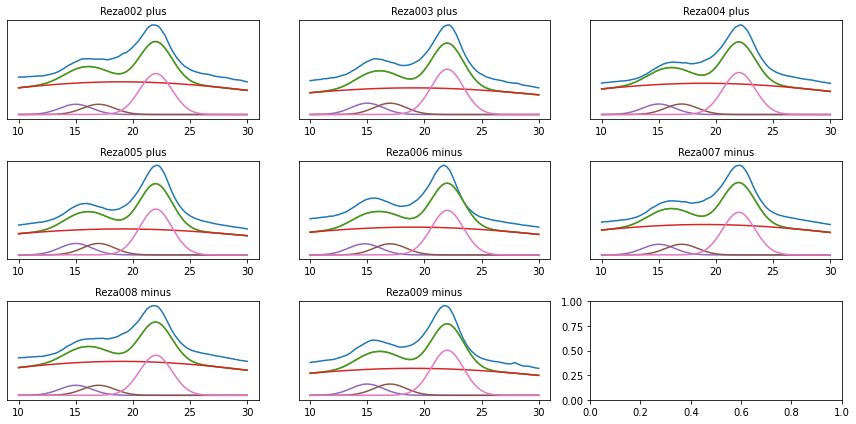

In [10]:
# equatorial radial profile
radial_eq=[]
sp_num=len(radial_eq_names)
n_cols=3
n_rows=round(sp_num/n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,int(n_rows*2)))

def func(x, a, b, c, d, e, f, g, h, i, j, k, l):
    return a * np.exp(-(b-x)**2/c**2) + d * np.exp(-(e-x)**2/f**2) + g * np.exp(-(h-x)**2/i**2)+j * np.exp(-(k-x)**2/l**2)

eq_min=10.0
eq_max=30.0

for i, fl_name in enumerate(radial_eq_names):
    df_from_pkl = pd.read_pickle(os.path.join(profile_path,fl_name)) # from profile
    x=df_from_pkl.index.values # 10 degree to 30 degree
    y=df_from_pkl.values # 10 degree to 30 degree
    y_max=df_from_pkl.values.max()
    y_min=df_from_pkl.values.min()
    am_max=df_from_pkl.values.min()
    I002=(y_max-y_min)*0.6
    p0=[0.2*I002,14.6,2,0.2*I002, 16.4, 2,I002,22.8,2,0.7*am_max,18.5,10]
    lower_bounds=[0.1*I002,14,1,0.1*I002,16,1,0.4*I002,22,1,0.5*am_max,18,10]
    upper_bounds=[0.3*I002,15,2,0.3*I002,17,2,1.2*I002,23,2,am_max,19,20]
    popt, pcov = curve_fit(func, x,y,p0,bounds=(lower_bounds,upper_bounds), maxfev = 1000000)
    y_pred = func(x, *popt)

    q,mod=divmod(i,n_cols)

    axes[q,mod].plot(x,y)
    axes[q,mod].set_title(fl_name.split('_')[0]+' '+fl_name.split('_')[1], fontsize=10)
    axes[q,mod].plot(x,y_pred)
    axes[q,mod].plot(x,y_pred)
    for k in list(range(4)):
        axes[q,mod].plot(x,gaussf(x,popt[3*(k-1)+0],popt[3*(k-1)+1],popt[3*(k-1)+2]))
    axes[q,mod].set(yticklabels=[])  # remove the tick labels
    axes[q,mod].tick_params(left=False) 
       
    radial_eq.append(popt)

fig.tight_layout()
plt.savefig(os.path.join(t_dir,'equatorial_line_broadening'), dpi=300)
plt.show()       

df=pd.DataFrame(radial_eq,index=radial_eq_names,columns=['(-110)','2-theta','sigma','(110)','2-theta','sigma',\
                                                        '(200)','2-theta','sigma','amorph','2-theta','sigma'])
with pd.ExcelWriter(res, engine="openpyxl", mode="a") as writer:
     df.to_excel(writer, sheet_name='equatorial_line_broadening')

### deconvolution of meridional (004) azimuthal profile (measure of MFA)

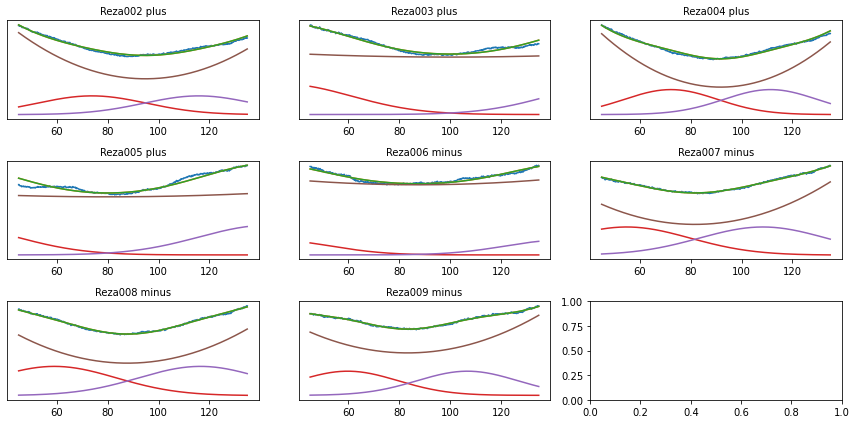

In [11]:
sp_num=len(azimuth_004_names)
n_cols=3
n_rows=round(sp_num/n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,int(n_rows*2)))

def bgf(x,a):
    return x*0+a

def bgf2(x,a,b,c):
    return a*(x-b)**2+c

# list(np.where(x==40)[0]),list(np.where(x==140)[0])
    
# azimuthal profile
azimuth_004=[]
for i, fl_name in enumerate(azimuth_004_names):
    df_from_pkl = pd.read_pickle(os.path.join(profile_path,fl_name)) # from profile
    x=df_from_pkl.index.values 
    y=df_from_pkl.values 
    y_max=df_from_pkl.values.max()
    y_min=df_from_pkl.values.min()
    def func(x, a, b, c, d, e, f):
        return a * np.exp(-(b-d-x)**2/c**2) + a * np.exp(-(b+d-x)**2/c**2) + e*(x-b)**2 +f
    I004=(y_max-y_min)
    
    p0=[I004,90,10,15,2,y_min]
    lower_bounds=[0.6*I004,80,2,1,0.01,0.5*y_min]
    upper_bounds=[1*I004,100,50, 100,130,y_min]
    
    popt, pcov = curve_fit(func, x,y, p0,bounds=(lower_bounds,upper_bounds), maxfev = 100000)
    y_pred = func(x, *popt)
    
    q,mod=divmod(i,n_cols)
    
    axes[q,mod].plot(x,y)
    axes[q,mod].set_title(fl_name.split('_')[0]+' '+fl_name.split('_')[1], fontsize=10)
    axes[q,mod].plot(x,y_pred)
    axes[q,mod].plot(x,y_pred)
    
    axes[q,mod].plot(x,gaussf(x,popt[0],popt[1]-popt[3],popt[2]))
    axes[q,mod].plot(x,gaussf(x,popt[0],popt[1]+popt[3],popt[2]))
    axes[q,mod].plot(x,bgf2(x,popt[4],popt[1],popt[5]))
    #axes[q,mod].plot(x,bgf(x,popt[5]))
    
    axes[q,mod].set(yticklabels=[])  # remove the tick labels
    axes[q,mod].tick_params(left=False) 
    
    azimuth_004.append(popt)
fig.tight_layout()
plt.savefig(os.path.join(t_dir,'MFA_(004)'), dpi=300)
plt.show()       


pd.options.display.precision = 2
df=pd.DataFrame(azimuth_004,index=azimuth_004_names,columns=['(004)','center','sigma','MFA','slope','background'])

with pd.ExcelWriter(res, engine="openpyxl", mode="a") as writer:
     df.to_excel(writer, sheet_name='MFA_(004)')

### deconvolution of equatorial (200) azimuthal profile (measure of MFA)

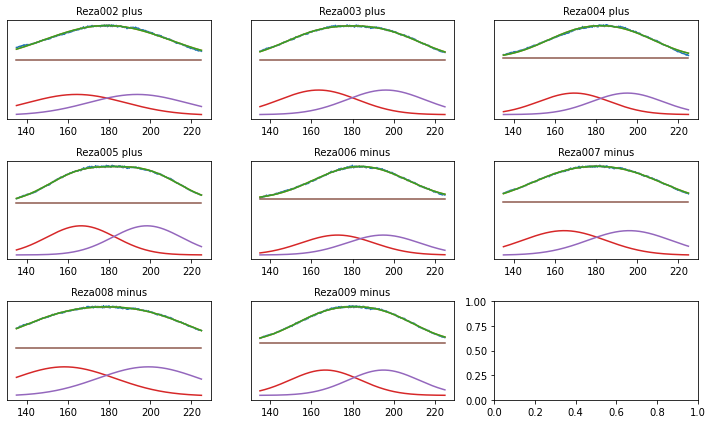

In [12]:
sp_num=len(azimuth_eq_names)
n_cols=3
n_rows=round(sp_num/n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10,int(n_rows*2)))

def bgf(x,a):
    return x*0+a

# list(np.where(x==140)[0]),list(np.where(x==220)[0])
    
# azimuthal profile
azimuth_eq=[]
for i, fl_name in enumerate(azimuth_eq_names):
    df_from_pkl = pd.read_pickle(os.path.join(profile_path,fl_name)) # from profile
    x=df_from_pkl.index.values 
    y=df_from_pkl.values 
    y_max=df_from_pkl.values.max()
    y_min=df_from_pkl.values.min()
    
    def func(x, a, b, c, d, e):
        return a * np.exp(-(b-d-x)**2/c**2) + a * np.exp(-(b+d-x)**2/c**2) + e
    
    I200=(y_max-y_min)*0.8
    p0=[I200,180,15,15,y_min*0.9]
    lower_bounds=[0.5*I200,150,10,10,0.8*y_min]
    upper_bounds=[1*I200,210,20,30,y_min]

    
    popt, pcov = curve_fit(func, x,y, p0, maxfev = 100000)
    y_pred = func(x, *popt)
    
    q,mod=divmod(i,n_cols)
    
    axes[q,mod].plot(x,y)
    axes[q,mod].set_title(fl_name.split('_')[0]+' '+fl_name.split('_')[1], fontsize=10)
    axes[q,mod].plot(x,y_pred)
    axes[q,mod].plot(x,y_pred)
    
    axes[q,mod].plot(x,gaussf(x,popt[0],popt[1]-popt[3],popt[2]))
    axes[q,mod].plot(x,gaussf(x,popt[0],popt[1]+popt[3],popt[2]))
    axes[q,mod].plot(x,bgf(x,popt[4]))
    
    axes[q,mod].set(yticklabels=[])  # remove the tick labels
    axes[q,mod].tick_params(left=False) 
    
    azimuth_eq.append(popt)
fig.tight_layout()
plt.savefig(os.path.join(t_dir,'MFA_(200)'), dpi=300)
plt.show()    


df=pd.DataFrame(azimuth_eq,index=azimuth_eq_names,columns=['(200)','center','sigma','MFA','background'])
pd.options.display.precision = 2
with pd.ExcelWriter(res, engine="openpyxl", mode="a") as writer:
     df.to_excel(writer, sheet_name='MFA_(200)')

### Assuming additional gaussian peak at 180 degree

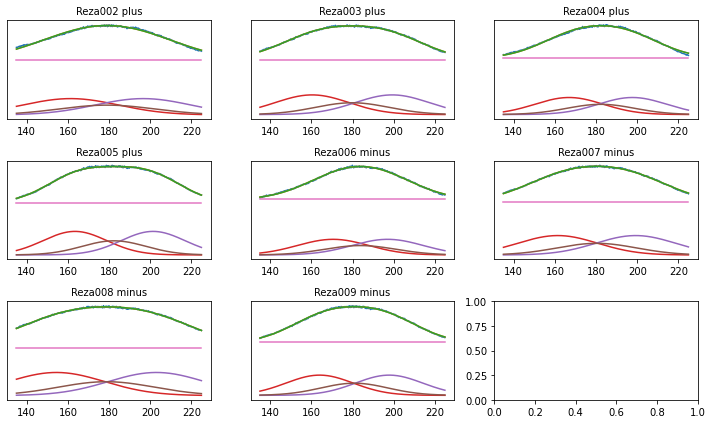

In [13]:
sp_num=len(azimuth_eq_names)
n_cols=3
n_rows=round(sp_num/n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10,int(n_rows*2)))

def bgf(x,a):
    return x*0+a

# list(np.where(x==140)[0]),list(np.where(x==220)[0])
    
# azimuthal profile
azimuth_eq=[]
for i, fl_name in enumerate(azimuth_eq_names):
    df_from_pkl = pd.read_pickle(os.path.join(profile_path,fl_name)) # from profile
    x=df_from_pkl.index.values 
    y=df_from_pkl.values 
    y_max=df_from_pkl.values.max()
    y_min=df_from_pkl.values.min()
    
    k=0.6
    def func(x, a, b, c, d, e):
        k = 0.6
        return a * np.exp(-(b-d-x)**2/c**2) + a * np.exp(-(b+d-x)**2/c**2) + a*k* np.exp(-(b-x)**2/c**2) +e
    
    I200=(y_max-y_min)*0.8
    p0=[I200,180,15,15,y_min*0.9]
    lower_bounds=[0.5*I200,150,10,10,0.8*y_min]
    upper_bounds=[1*I200,210,20,30,y_min]

    
    popt, pcov = curve_fit(func, x,y, p0, maxfev = 100000)
    y_pred = func(x, *popt)
    
    q,mod=divmod(i,n_cols)
    
    axes[q,mod].plot(x,y)
    axes[q,mod].set_title(fl_name.split('_')[0]+' '+fl_name.split('_')[1], fontsize=10)
    axes[q,mod].plot(x,y_pred)
    axes[q,mod].plot(x,y_pred)
    
    axes[q,mod].plot(x,gaussf(x,popt[0],popt[1]-popt[3],popt[2]))
    axes[q,mod].plot(x,gaussf(x,popt[0],popt[1]+popt[3],popt[2]))
    axes[q,mod].plot(x,gaussf(x,popt[0]*k,popt[1],popt[2]))
    axes[q,mod].plot(x,bgf(x,popt[4]))
    
    axes[q,mod].set(yticklabels=[])  # remove the tick labels
    axes[q,mod].tick_params(left=False) 
    
    azimuth_eq.append(popt)
fig.tight_layout()
plt.savefig(os.path.join(t_dir,'MFA_(200)'), dpi=300)
plt.show()    


df=pd.DataFrame(azimuth_eq,index=azimuth_eq_names,columns=['(200)','center','sigma','MFA','background'])
pd.options.display.precision = 2
with pd.ExcelWriter(res, engine="openpyxl", mode="a") as writer:
     df.to_excel(writer, sheet_name='MFA_(200) modified')

#### End of the program. 2021/4/24